In [2]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import Conv2D, MaxPooling2D, BatchNormalization, Conv2DTranspose, Dropout, Concatenate, Input, Activation
import matplotlib.pyplot as plt
import os
import cv2
from tensorflow.keras import Model
import tqdm

In [3]:
def double_conv2D(inputs, num_filters):
    x=Conv2D(num_filters, 3, padding='same')(inputs)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    x=Conv2D(num_filters, 3, padding='same')(x)
    x=BatchNormalization()(x)
    x=Activation('relu')(x)
    
    return x

In [4]:
def encoder_block(inputs, num_filters):
    x=double_conv2D(inputs, num_filters)
    p=MaxPooling2D((2, 2))(x)
    return x, p

In [5]:
def bottleneck(inputs, num_filters):
    x=double_conv2D(inputs, num_filters)
    return x

In [6]:
def decoder_block(inputs, skip_connections, num_filters):
    x=Conv2DTranspose(num_filters, (2, 2), strides=2, padding='same')(inputs)
    x=Concatenate()([skip_connections, x])
    x=double_conv2D(x, num_filters)
    return x

In [7]:
def build_unet(inputs):
    inputs=Input(inputs)
    
    #encoding
    x1, p1=encoder_block(inputs, 64)
    x2, p2=encoder_block(p1, 128)
    x3, p3=encoder_block(p2, 256)
    x4, p4=encoder_block(p3, 512)
    
    #bottleneck
    bott=bottleneck(p4, 1024)
    
    #decoding
    d1=decoder_block(bott, x4, 512)
    d2=decoder_block(d1, x3, 256)
    d3=decoder_block(d2, x2, 128)
    d4=decoder_block(d3, x1, 64)
    
    #output
    outputs=Conv2D(35, 1, padding='same')(d4)
    model=Model (inputs, outputs, name='U-Net')
    return model

In [8]:
model=build_unet((256, 256, 3))

In [9]:
model.summary()

Model: "U-Net"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 256,  │      1,792 │ input_layer[0][0] │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 256,  │        256 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 256,  │     36,928 │ activation[0][0]  │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 256,  │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 128,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 128,  │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 128,  │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 128,  │        512 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 128,  │          0 │ batch_normalizat… │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 64,    │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 64,    │      1,024 │ conv2d_4[0][0]  

 Total params: 31,057,507 (118.47 MB)

 Trainable params: 31,045,731 (118.43 MB)

 Non-trainable params: 11,776 (46.00 KB)

# Load data

In [10]:
data_path='kaggle/input/cityscapes-image-pairs/cityscapes_data'
train_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/train/'
val_path='/kaggle/input/cityscapes-image-pairs/cityscapes_data/val/'

In [11]:
train_img=sorted(os.listdir(train_path))
val_img=sorted(os.listdir(val_path))

In [12]:
from collections import namedtuple

Label = namedtuple( 'Label' , ['name','id','trainId','category','categoryId','hasInstances','ignoreInEval','color',] )

labels = [
    #       name                     id    trainId   category            catId     hasInstances   ignoreInEval   color
    Label(  'unlabeled'            ,  0 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'ego vehicle'          ,  1 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'rectification border' ,  2 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'out of roi'           ,  3 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'static'               ,  4 ,      255 , 'void'            , 0       , False        , True         , (  0,  0,  0) ),
    Label(  'dynamic'              ,  5 ,      255 , 'void'            , 0       , False        , True         , (111, 74,  0) ),
    Label(  'ground'               ,  6 ,      255 , 'void'            , 0       , False        , True         , ( 81,  0, 81) ),
    Label(  'road'                 ,  7 ,        0 , 'ground'          , 1       , False        , False        , (128, 64,128) ),
    Label(  'sidewalk'             ,  8 ,        1 , 'ground'          , 1       , False        , False        , (244, 35,232) ),
    Label(  'parking'              ,  9 ,      255 , 'ground'          , 1       , False        , True         , (250,170,160) ),
    Label(  'rail track'           , 10 ,      255 , 'ground'          , 1       , False        , True         , (230,150,140) ),
    Label(  'building'             , 11 ,        2 , 'construction'    , 2       , False        , False        , ( 70, 70, 70) ),
    Label(  'wall'                 , 12 ,        3 , 'construction'    , 2       , False        , False        , (102,102,156) ),
    Label(  'fence'                , 13 ,        4 , 'construction'    , 2       , False        , False        , (190,153,153) ),
    Label(  'guard rail'           , 14 ,      255 , 'construction'    , 2       , False        , True         , (180,165,180) ),
    Label(  'bridge'               , 15 ,      255 , 'construction'    , 2       , False        , True         , (150,100,100) ),
    Label(  'tunnel'               , 16 ,      255 , 'construction'    , 2       , False        , True         , (150,120, 90) ),
    Label(  'pole'                 , 17 ,        5 , 'object'          , 3       , False        , False        , (153,153,153) ),
    Label(  'polegroup'            , 18 ,      255 , 'object'          , 3       , False        , True         , (153,153,153) ),
    Label(  'traffic light'        , 19 ,        6 , 'object'          , 3       , False        , False        , (250,170, 30) ),
    Label(  'traffic sign'         , 20 ,        7 , 'object'          , 3       , False        , False        , (220,220,  0) ),
    Label(  'vegetation'           , 21 ,        8 , 'nature'          , 4       , False        , False        , (107,142, 35) ),
    Label(  'terrain'              , 22 ,        9 , 'nature'          , 4       , False        , False        , (152,251,152) ),
    Label(  'sky'                  , 23 ,       10 , 'sky'             , 5       , False        , False        , ( 70,130,180) ),
    Label(  'person'               , 24 ,       11 , 'human'           , 6       , True         , False        , (220, 20, 60) ),
    Label(  'rider'                , 25 ,       12 , 'human'           , 6       , True         , False        , (255,  0,  0) ),
    Label(  'car'                  , 26 ,       13 , 'vehicle'         , 7       , True         , False        , (  0,  0,142) ),
    Label(  'truck'                , 27 ,       14 , 'vehicle'         , 7       , True         , False        , (  0,  0, 70) ),
    Label(  'bus'                  , 28 ,       15 , 'vehicle'         , 7       , True         , False        , (  0, 60,100) ),
    Label(  'caravan'              , 29 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0, 90) ),
    Label(  'trailer'              , 30 ,      255 , 'vehicle'         , 7       , True         , True         , (  0,  0,110) ),
    Label(  'train'                , 31 ,       16 , 'vehicle'         , 7       , True         , False        , (  0, 80,100) ),
    Label(  'motorcycle'           , 32 ,       17 , 'vehicle'         , 7       , True         , False        , (  0,  0,230) ),
    Label(  'bicycle'              , 33 ,       18 , 'vehicle'         , 7       , True         , False        , (119, 11, 32) ),
    Label(  'license plate'        , 34 ,       19 , 'vehicle'         , 7       , False        , True         , (  0,  0,142) ),
]

In [13]:
id2color={label.id:np.asarray(label.color) for label in labels}

In [14]:
def image_mask_load(path):
    image_mask=cv2.imread(path)
    image=image_mask[:, :256]
    mask=image_mask[:, 256:]
    image=np.array(image)/255.0
    mask=np.array(mask)
    return image, mask

In [15]:
def find_closest_labels(mask, mapping):
    
    closest_distance = np.full([mask.shape[0], mask.shape[1]], 999999) 
    closest_category = np.full([mask.shape[0], mask.shape[1]], None)   

    for id, color in mapping.items(): # iterate over every color mapping
        dist = np.sqrt(np.linalg.norm(mask - color.reshape([1,1,-1]), axis=-1))
        is_closer = closest_distance > dist
        #print(is_closer)
        closest_distance = np.where(is_closer, dist, closest_distance)
        #print(closest_distance)
        closest_category = np.where(is_closer, id, closest_category)
        #print(closest_category)
    return closest_category

In [16]:
train_images = [] 
train_masks = []
train_masks_mapped = []
val_images = []
val_masks = []
val_masks_mapped = []
for path in train_img:
    image, mask=image_mask_load(os.path.join(train_path, path))
    train_images.append(image)
    train_masks.append(mask)
    train_masks_mapped.append(find_closest_labels(mask, id2color))

In [17]:
for path in val_img:
    image, mask=image_mask_load(os.path.join(train_path, path))
    val_images.append(image)
    val_masks.append(mask)
    val_masks_mapped.append(find_closest_labels(mask, id2color))

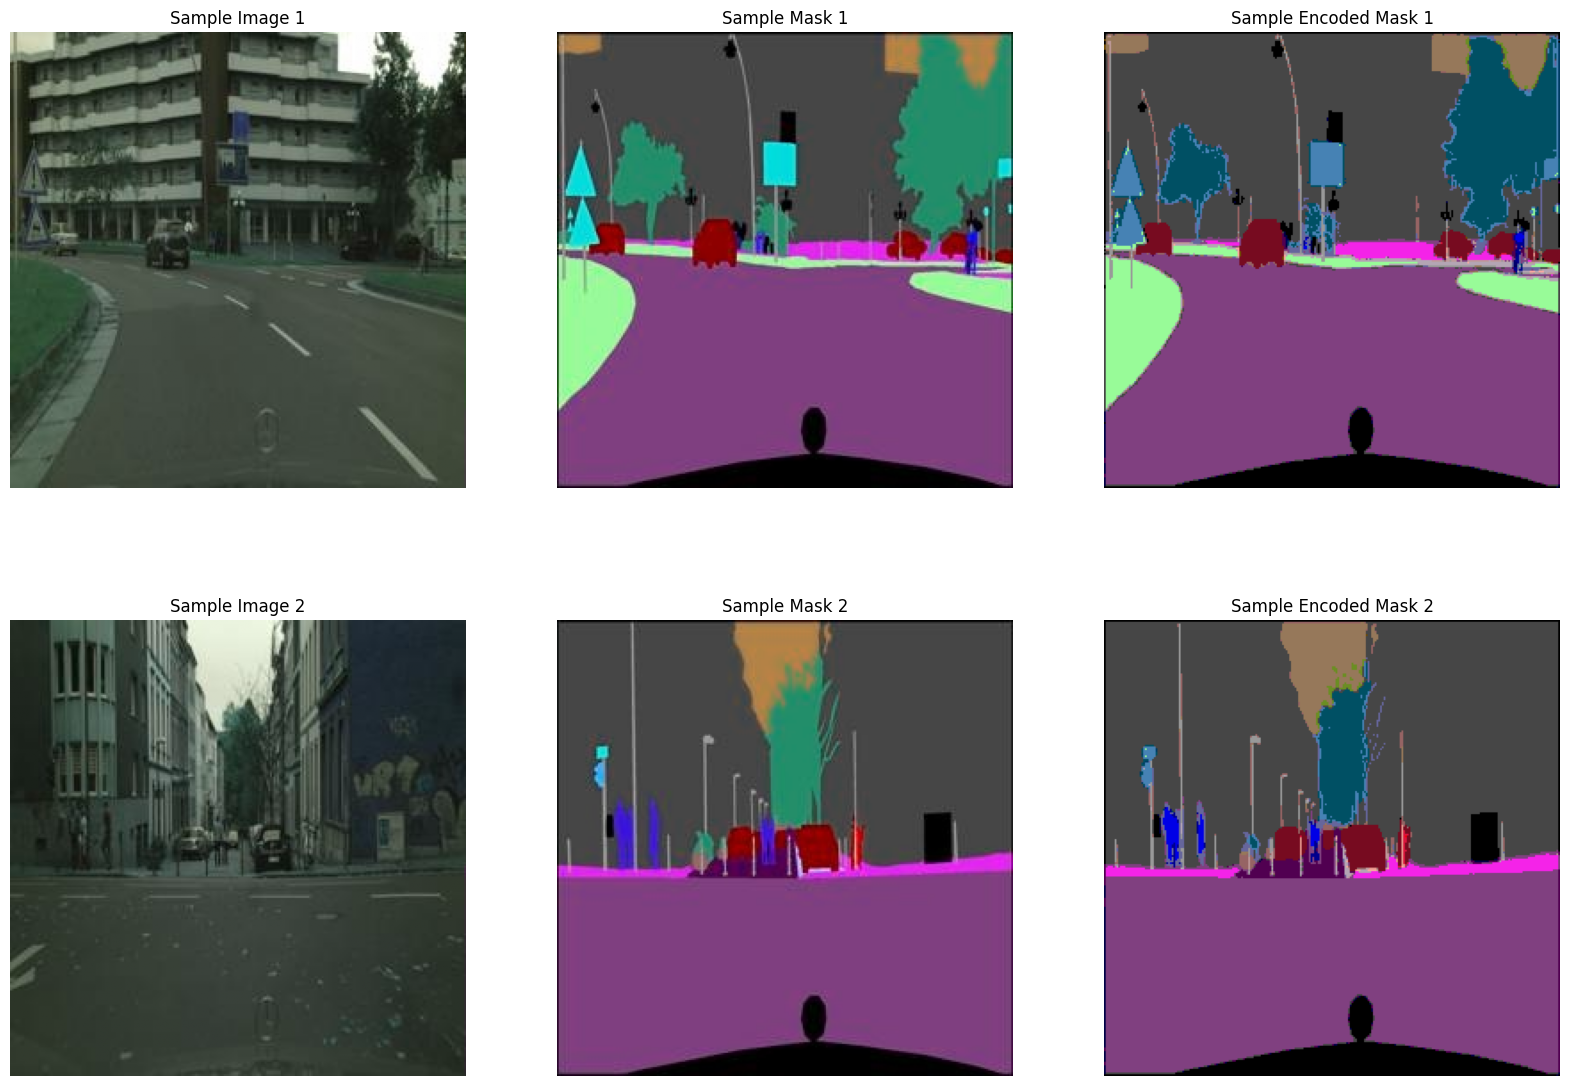

In [18]:
plt.figure(figsize=[20, 14])

for i in range(2):
    img = train_images[i]
    msk = train_masks[i]
    enc = train_masks_mapped[i]
    tmp = np.zeros([enc.shape[0], enc.shape[1], 3])
    
    for row in range(enc.shape[0]):
        for col in range(enc.shape[1]):
            tmp[row, col, :] = id2color[enc[row, col]]
            tmp = tmp.astype('uint8')
            
    plt.subplot(2, 3, i*3 + 1)
    plt.imshow(img)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 2)
    plt.imshow(msk)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(2, 3, i*3 + 3)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))

In [19]:
del train_masks, val_masks

In [20]:
train_images = np.stack(train_images).astype('float32')
train_masks_mapped = np.stack(train_masks_mapped).astype('float32')

val_images = np.stack(val_images).astype('float32')
val_masks_mapped = np.stack(val_masks_mapped).astype('float32')

In [21]:
train_masks_mapped.shape

(2975, 256, 256)

In [22]:
train_images.shape

(2975, 256, 256, 3)

In [23]:
model_checkpoint = './cityscapes-unet.keras'

In [24]:
model.compile(optimizer = 'adam',
              loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics = ['accuracy'])

model_checkpoint = ModelCheckpoint(model_checkpoint,
                                   monitor='val_accuracy',
                                   save_best_only=True,
                                   verbose=1,
                                   mode = 'max')

callbacks = [model_checkpoint]

history = model.fit(x = train_images,
                    y = train_masks_mapped,
                    batch_size = 6,
                    epochs = 60,
                    validation_data = (val_images, val_masks_mapped),
                    callbacks=callbacks)

Epoch 1/60


2024-03-14 08:09:26.831115: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.13039, expected 2.54847
2024-03-14 08:09:26.831189: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.06686, expected 3.48494
2024-03-14 08:09:26.831210: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.75322, expected 4.1713
2024-03-14 08:09:26.831226: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 8: 4.68977, expected 4.10784
2024-03-14 08:09:26.831238: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 9: 4.43621, expected 3.85429
2024-03-14 08:09:26.831250: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 20: 4.29776, expected 3.71584
2024-03-14 08:09:26.831261: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 21: 4.58573, expected 4.00381
2024-03-14 08:09:26.831273: E external/local_xla/xla/s

  1/496 ━━━━━━━━━━━━━━━━━━━━ 5:59:27 44s/step - accuracy: 0.0314 - loss: 3.8329

I0000 00:00:1710403795.415529     152 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


495/496 ━━━━━━━━━━━━━━━━━━━━ 0s 165ms/step - accuracy: 0.6645 - loss: 1.3551

2024-03-14 08:11:18.729731: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65364: 2.53678, expected 2.17699
2024-03-14 08:11:18.729809: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65380: 2.56388, expected 2.20409
2024-03-14 08:11:18.729826: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65381: 2.54569, expected 2.1859
2024-03-14 08:11:18.729839: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 65482: 2.57729, expected 2.2175
2024-03-14 08:11:18.730308: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131072: 3.63821, expected 2.67835
2024-03-14 08:11:18.730342: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131073: 5.0582, expected 4.09834
2024-03-14 08:11:18.730355: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 131074: 5.50194, expected 4.54208
2024-03-14 08:11:18.730368:

496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 219ms/step - accuracy: 0.6646 - loss: 1.3545

2024-03-14 08:11:51.055358: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 3.25729, expected 2.60868
2024-03-14 08:11:51.055421: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 3.51493, expected 2.86632
2024-03-14 08:11:51.055438: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.30991, expected 3.6613
2024-03-14 08:11:51.055453: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 4.61844, expected 3.96984
2024-03-14 08:11:51.055465: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 4.70488, expected 4.05627
2024-03-14 08:11:51.055476: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.11794, expected 4.46933
2024-03-14 08:11:51.055488: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 7: 4.56915, expected 3.92054
2024-03-14 08:11:51.055499: E external/local_xla/xla/ser


Epoch 1: val_accuracy improved from -inf to 0.70159, saving model to ./cityscapes-unet.keras
496/496 ━━━━━━━━━━━━━━━━━━━━ 165s 245ms/step - accuracy: 0.6647 - loss: 1.3539 - val_accuracy: 0.7016 - val_loss: 1.0771
Epoch 2/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7613 - loss: 0.8491
Epoch 2: val_accuracy improved from 0.70159 to 0.77766, saving model to ./cityscapes-unet.keras
496/496 ━━━━━━━━━━━━━━━━━━━━ 88s 177ms/step - accuracy: 0.7613 - loss: 0.8490 - val_accuracy: 0.7777 - val_loss: 0.7952
Epoch 3/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 164ms/step - accuracy: 0.7902 - loss: 0.7487
Epoch 3: val_accuracy did not improve from 0.77766
496/496 ━━━━━━━━━━━━━━━━━━━━ 86s 173ms/step - accuracy: 0.7902 - loss: 0.7487 - val_accuracy: 0.7750 - val_loss: 0.8099
Epoch 4/60
496/496 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step - accuracy: 0.8069 - loss: 0.6900
Epoch 4: val_accuracy improved from 0.77766 to 0.81080, saving model to ./cityscapes-unet.keras
496/496 ━━━━━━━━━━━━━━━━━━━━ 87s 176ms

In [26]:
test_result=model.predict(test)

2024-03-14 09:40:04.615254: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 0: 2.86272, expected 2.0465
2024-03-14 09:40:04.615322: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 1: 4.04967, expected 3.23345
2024-03-14 09:40:04.615331: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 2: 4.4326, expected 3.61638
2024-03-14 09:40:04.615340: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 3: 5.46868, expected 4.65247
2024-03-14 09:40:04.615347: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 4: 5.37814, expected 4.56193
2024-03-14 09:40:04.615356: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 5: 5.18374, expected 4.36753
2024-03-14 09:40:04.615364: E external/local_xla/xla/service/gpu/buffer_comparator.cc:1137] Difference at 6: 5.54872, expected 4.7325
2024-03-14 09:40:04.615372: E external/local_xla/xla/servi

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


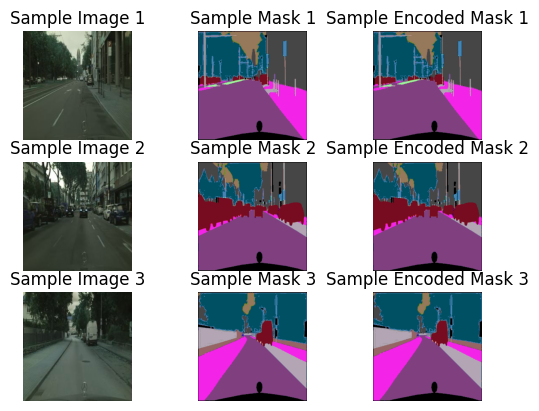

In [49]:
for i in range(3):
    sample=np.random.randint(0, 200)
    test=train_images[sample]
    test_mask=train_masks_mapped[sample]
    test_result = model.predict(test.reshape([1] + [256, 256, 3]))
    test_result = np.squeeze(np.argmax(test_result, axis=-1))

    for row in range(test_mask.shape[0]):
        for col in range(test_mask.shape[1]):
            tmp[row, col, :] = id2color[test_mask[row, col]]
            tmp = tmp.astype('uint8')
    for row in range(test_mask.shape[0]):
        for col in range(test_mask.shape[1]):
            tmp_res[row, col, :] = id2color[test_result[row, col]]
            tmp_res = tmp.astype('uint8')
    plt.subplot(3, 3, i*3 + 1)
    plt.imshow(test)
    plt.axis('off')
    plt.gca().set_title('Sample Image {}'.format(str(i+1)))
    
    plt.subplot(3, 3, i*3 + 2)
    plt.imshow(tmp)
    plt.axis('off')
    plt.gca().set_title('Sample Mask {}'.format(str(i+1)))
    
    plt.subplot(3, 3, i*3 + 3)
    plt.imshow(tmp_res)
    plt.axis('off')
    plt.gca().set_title('Sample Encoded Mask {}'.format(str(i+1)))